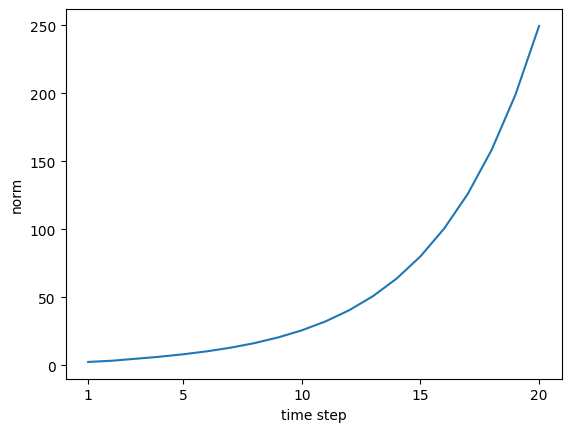

In [3]:
# 기울기 폭발
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차워 수 
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()


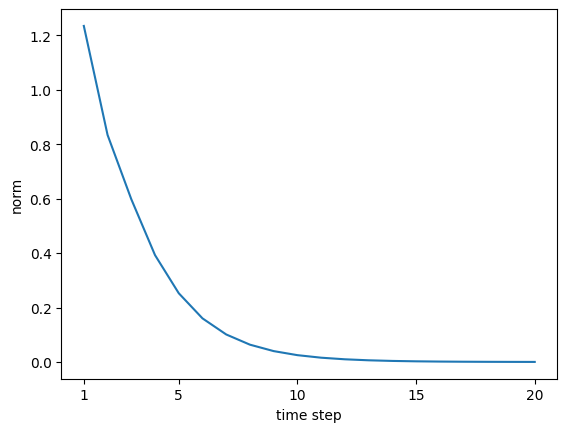

In [5]:
# 기울기 소실
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차워 수 
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()


In [6]:
# 기울기 폭발 대책 -> 기울기 클리핑
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(self, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1: # 문턱값을 넘어갈시 0.~
        for grad in grads: # 기울기 수정 
            grad *= rate

In [11]:
# 기울기 소실 대책 LSTM
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x,Wx) + np.matmul(h_prev,Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = c_prev * f + g * i 
        h_next = o + np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params 
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next**2)
        
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f (1 - f)
        do *= o (1 - o)
        dg *= (1 - g**2)
        
        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = b
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

In [8]:
# 1D 배열(벡터)에 대해 np.dot 사용
a = np.array([1, 2])
b = np.array([3, 4])
print(np.dot(a, b))  # 결과: 1*3 + 2*4 = 11

# 2D 배열(행렬)에 대해 np.dot 사용
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
print(np.dot(a, b))  # 행렬 곱셈 결과: [[19 22], [43 50]]


11
[[19 22]
 [43 50]]


In [9]:
# 1D 배열에 대해 np.matmul 사용
a = np.array([1, 2])
b = np.array([3, 4])
print(np.matmul(a, b))  # 결과: 1*3 + 2*4 = 11

# 2D 배열에 대해 np.matmul 사용
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
print(np.matmul(a, b))  # 행렬 곱셈 결과: [[19 22], [43 50]]


11
[[19 22]
 [43 50]]


In [17]:
a = np.random.rand(2, 3, 4)
b = np.random.rand(2, 4, 5)

# np.dot을 사용
print(np.dot(a, b).shape)  # (2, 3, 2, 5) - 마지막 축과 두 번째 축 기준으로 곱셈 수행

# np.matmul을 사용
print(np.matmul(a, b).shape)  # (2, 3, 5) - 각 배열을 2D처럼 간주하고 곱셈 수행


(2, 3, 2, 5)
(2, 3, 5)


In [21]:
a = np.array([1, 2, 3])
b = 3

# np.dot
result_dot = np.dot(a, b)
print(result_dot)  

[3 6 9]


In [22]:
# np.matmul
result_matmul = np.matmul(a, b)
print(result_matmul)  

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [24]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_llike(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.parmas
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype = 'f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, H), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dh[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dxs
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None

In [25]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.30
| 에폭 1 |  반복 21 / 1327 | 시간 2[s] | 퍼플렉서티 2772.35
| 에폭 1 |  반복 41 / 1327 | 시간 5[s] | 퍼플렉서티 1236.14
| 에폭 1 |  반복 61 / 1327 | 시간 8[s] | 퍼플렉서티 961.87
| 에폭 1 |  반복 81 / 1327 | 시간 11[s] | 퍼플렉서티 775.01
| 에폭 1 |  반복 101 / 1327 | 시간 14[s] | 퍼플렉서티 662.05
| 에폭 1 |  반복 121 / 1327 | 시간 17[s] | 퍼플렉서티 644.89
| 에폭 1 |  반복 141 / 1327 | 시간 21[s] | 퍼플렉서티 591.93
| 에폭 1 |  반복 161 / 1327 | 시간 24[s] | 퍼플렉서티 578.30
| 에폭 1 |  반복 181 / 1327 | 시간 27[s] | 퍼플렉서티 588.31
| 에폭 1 |  반복 201 / 1327 | 시간 29[s] | 퍼플렉서티 499.05
| 에폭 1 |  반복 221 / 1327 | 시간 32[s] | 퍼플렉서티 485.85
| 에폭 1 |  반복 241 / 1327 | 시간 35[s] | 퍼플렉서티 438.92
| 에폭 1 |  반복 261 / 1327 | 시간 38[s] | 퍼플렉서티 458.70
| 에폭 1 |  반복 281 / 1327 | 시간 40[s] | 퍼플렉서티 455.40
| 에폭 1 |  반복 301 / 1327 | 시간 43[s] | 퍼플렉서티 392.97
| 에폭 1 |  반복 321 / 1327 | 시간 45[s] | 퍼플렉서티 344.93
| 에폭 1 |  반복 341 / 1327 | 시간 48[s] | 퍼플렉서티 402.08
| 에폭 1 |  반복 361 / 1327 | 시간 50[s] | 퍼플렉서티 406.11
| 에폭 1 |  반복 381 / 1327 | 시간 53[s] | 퍼플렉서티 331.09
| 에폭 1

| 에폭 3 |  반복 561 / 1327 | 시간 417[s] | 퍼플렉서티 119.00
| 에폭 3 |  반복 581 / 1327 | 시간 420[s] | 퍼플렉서티 104.73
| 에폭 3 |  반복 601 / 1327 | 시간 423[s] | 퍼플렉서티 148.07
| 에폭 3 |  반복 621 / 1327 | 시간 425[s] | 퍼플렉서티 142.30
| 에폭 3 |  반복 641 / 1327 | 시간 428[s] | 퍼플렉서티 128.87
| 에폭 3 |  반복 661 / 1327 | 시간 431[s] | 퍼플렉서티 122.12
| 에폭 3 |  반복 681 / 1327 | 시간 433[s] | 퍼플렉서티 100.54
| 에폭 3 |  반복 701 / 1327 | 시간 436[s] | 퍼플렉서티 118.73
| 에폭 3 |  반복 721 / 1327 | 시간 439[s] | 퍼플렉서티 127.22
| 에폭 3 |  반복 741 / 1327 | 시간 441[s] | 퍼플렉서티 107.53
| 에폭 3 |  반복 761 / 1327 | 시간 444[s] | 퍼플렉서티 102.56
| 에폭 3 |  반복 781 / 1327 | 시간 446[s] | 퍼플렉서티 104.46
| 에폭 3 |  반복 801 / 1327 | 시간 449[s] | 퍼플렉서티 115.39
| 에폭 3 |  반복 821 / 1327 | 시간 452[s] | 퍼플렉서티 115.76
| 에폭 3 |  반복 841 / 1327 | 시간 454[s] | 퍼플렉서티 115.25
| 에폭 3 |  반복 861 / 1327 | 시간 457[s] | 퍼플렉서티 121.20
| 에폭 3 |  반복 881 / 1327 | 시간 459[s] | 퍼플렉서티 105.93
| 에폭 3 |  반복 901 / 1327 | 시간 462[s] | 퍼플렉서티 131.38
| 에폭 3 |  반복 921 / 1327 | 시간 465[s] | 퍼플렉서티 118.49
| 에폭 3 |  반복 941 / 1327 | 시간 46

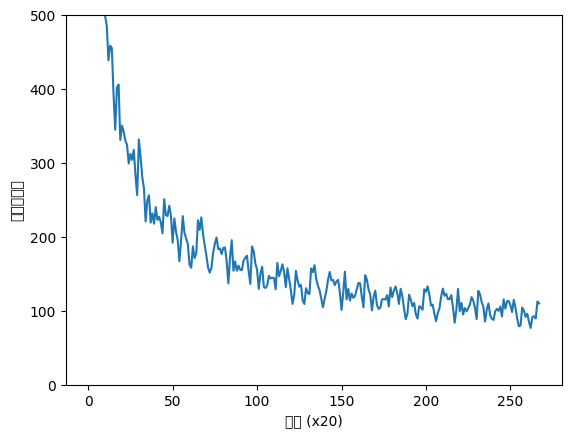

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  136.16014240317745


In [28]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()


In [29]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros_like(4*H).astype('f')
        lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros_like(4*H).astype('f')
        affine_b = np.zeros_like(4*V).astype('f')
        
        # 세가지 개선
        self.layers =[
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 가중치 공유
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.retset_state()

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)


In [32]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 학습된 모델 파일 불러오기
model_path = 'BetterRnnlm.pkl'

# 하이퍼파라미터 설정
wordvec_size = 650
hidden_size = 650
dropout = 0.5

# 테스트 데이터 읽기
corpus_test, word_to_id, id_to_word = ptb.load_data('test')

if config.GPU:
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)

# 모델 생성 및 파라미터 로드
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
model.load_params(model_path)

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)


퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  75.76414066440604
